<a href="https://colab.research.google.com/github/meligurevich/IAA2/blob/main/MELISAGUREVICH_TP1_entorno_discreto_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

#### **MELISA SABRINA GUREVICH - DNI: 35.365.884**

En este trabajo exploramos tres formas distintas de enseñar a un agente a tomar decisiones en el entorno FrozenLake.

## Instalar librerias

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Reproducibilidad

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Crear el entorno

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [ ]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [ ]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [ ]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [ ]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [ ]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.020
Episodio 400: Tasa de éxito = 0.015
Episodio 600: Tasa de éxito = 0.013
Episodio 800: Tasa de éxito = 0.016
Episodio 1000: Tasa de éxito = 0.017

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.017
Recompensa promedio: 0.017


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

In [ ]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización

In [ ]:
politica_aleatoria

array([2, 3, 3, 2, 1, 0, 3, 1, 0, 3, 3, 2, 0, 1, 1, 1])

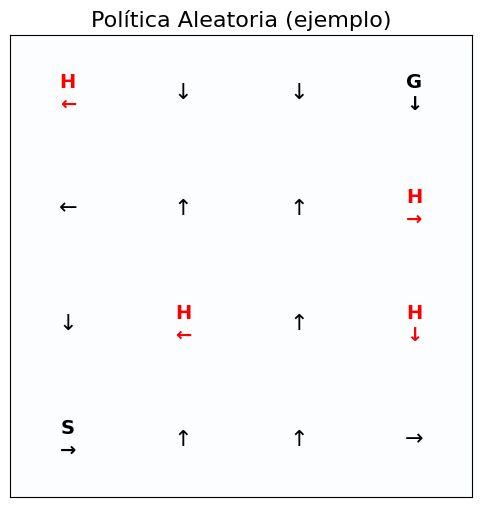

In [ ]:

visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [ ]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [ ]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.160, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [ ]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.123
Pasos promedio: 16.3


## Visualizar política aprendida

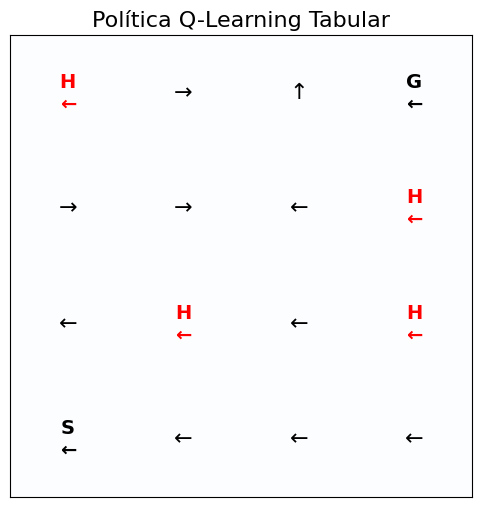

In [ ]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

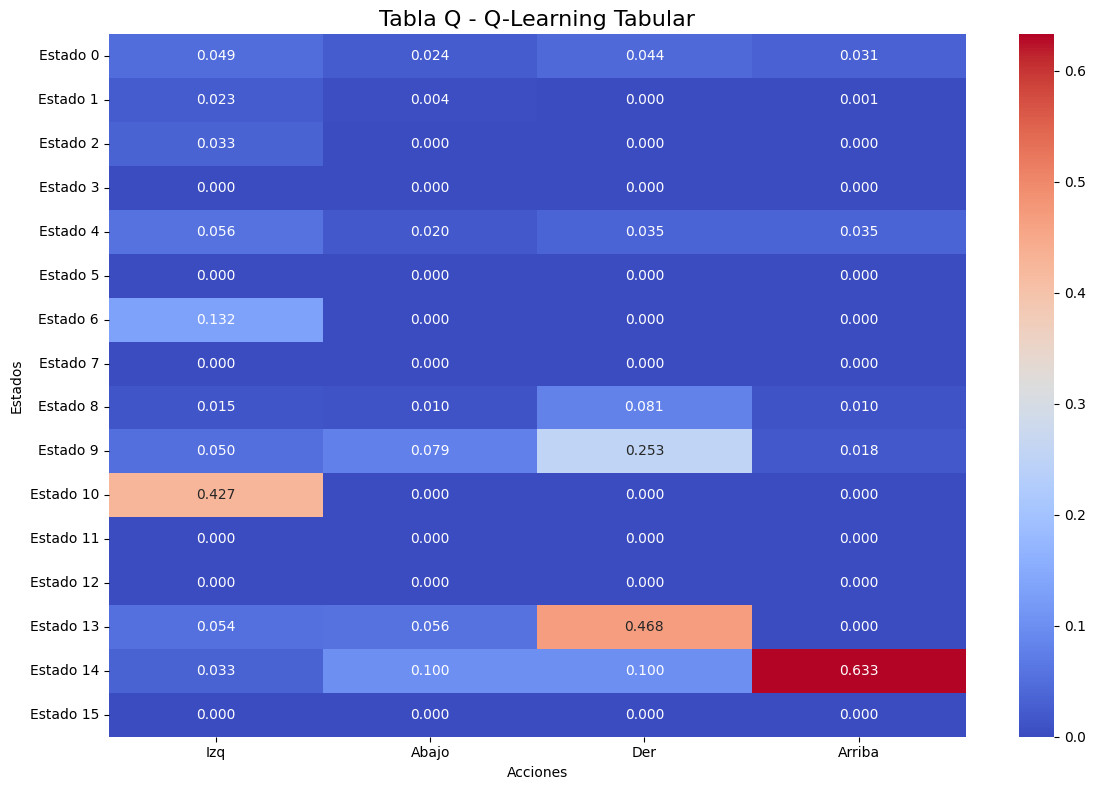

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [ ]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [ ]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [ ]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [ ]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.070, Epsilon = 0.367, Loss = 0.0093
Episodio 400: Tasa éxito = 0.200, Epsilon = 0.135, Loss = 0.0076
Episodio 600: Tasa éxito = 0.340, Epsilon = 0.049, Loss = 0.0079
Episodio 800: Tasa éxito = 0.490, Epsilon = 0.018, Loss = 0.0077
Episodio 1000: Tasa éxito = 0.550, Epsilon = 0.010, Loss = 0.0077

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [ ]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.270
Pasos promedio: 17.9


## Visualizar política aprendida

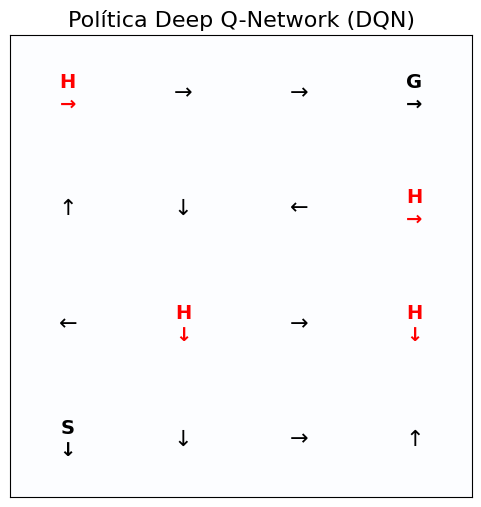

In [ ]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [ ]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.017
Q-Learning Tabular:    Tasa de éxito = 0.123
Deep Q-Network (DQN):  Tasa de éxito = 0.270


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [ ]:
len(recompensas_aleatorio)

1000

In [ ]:
len(recompensas_qlearning)

1000

In [ ]:
len(recompensas_dqn)

1000

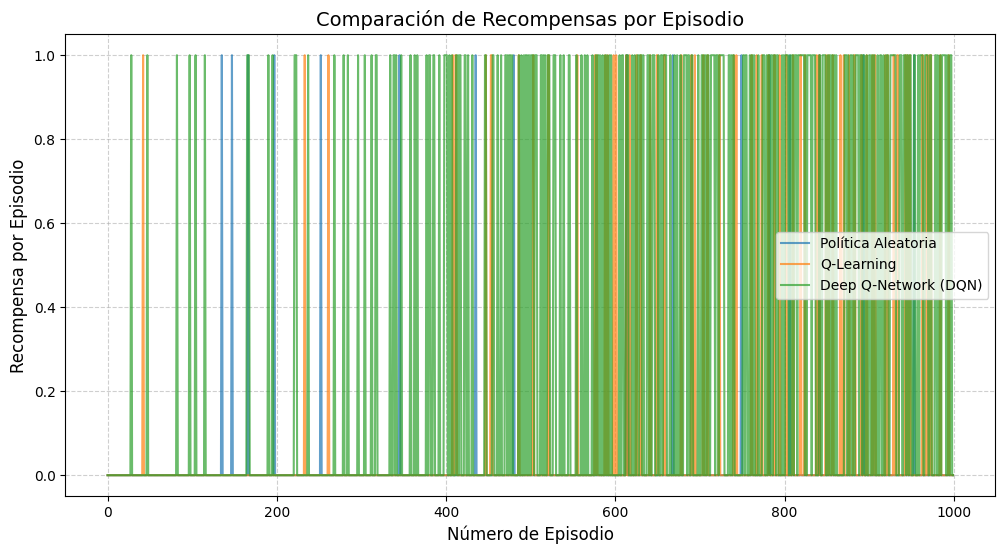

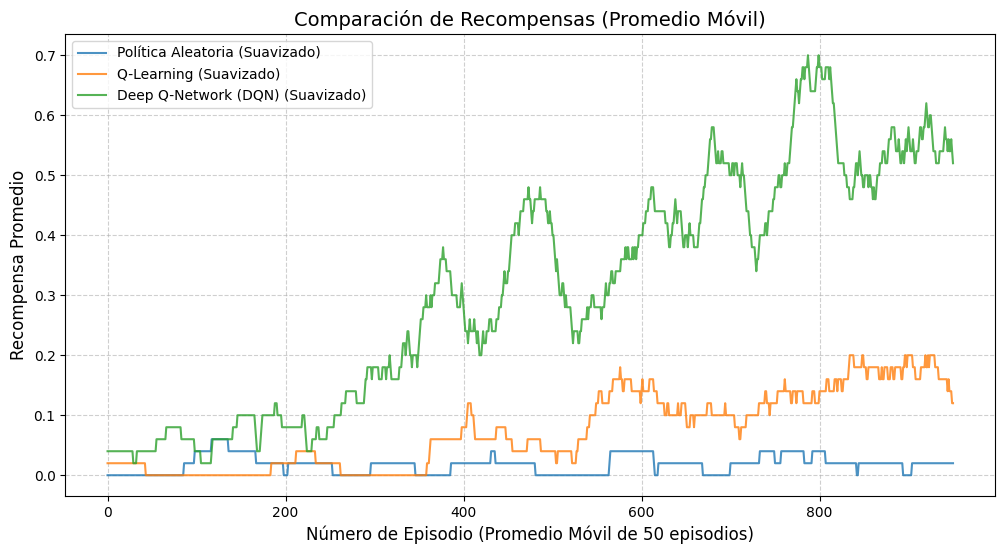

In [ ]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

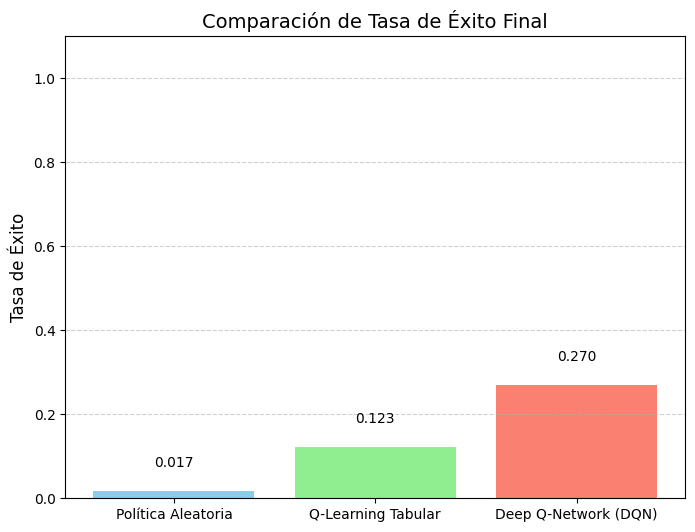

In [ ]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Evolución de Epsilon (solo para algoritmos que usan exploración)

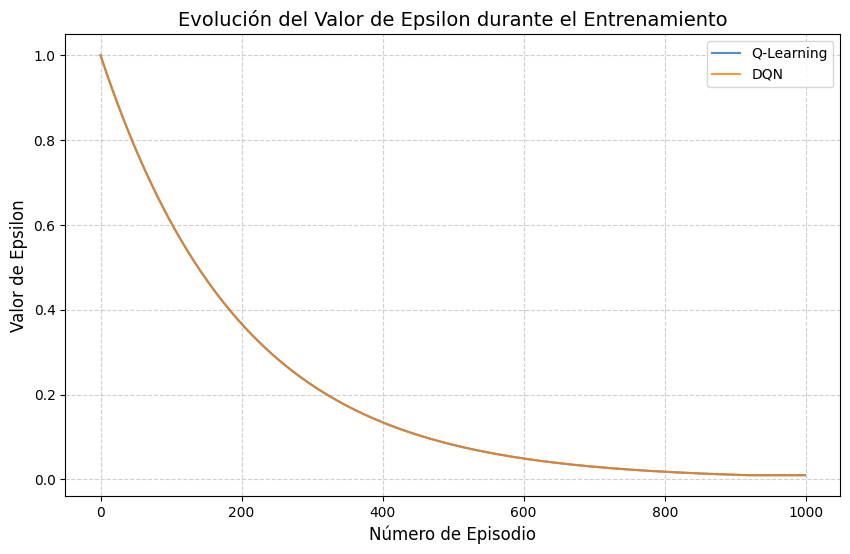

In [ ]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### DQN pérdida

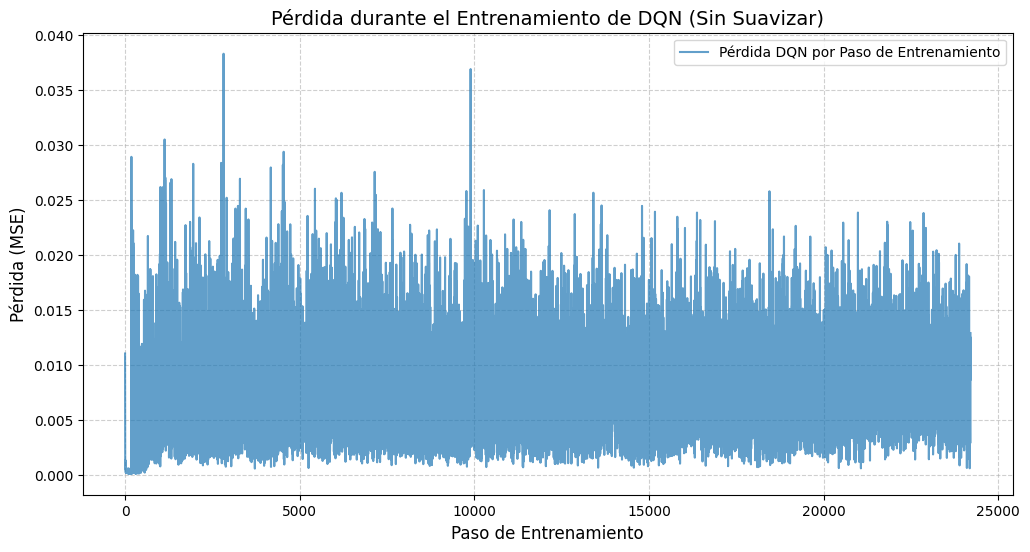

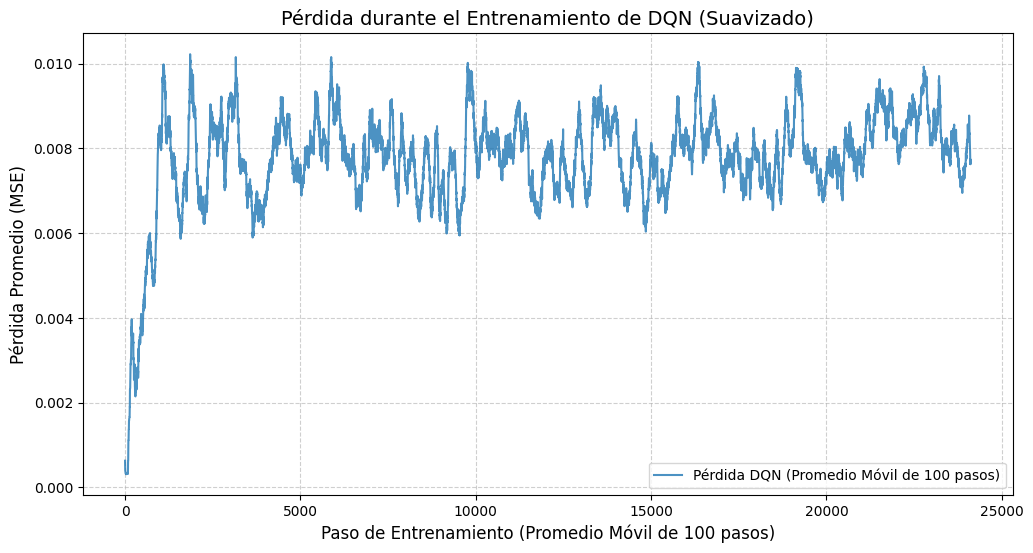

In [ ]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

- Política Aleatoria: el agente se mueve sin una estrategia y no aprende de la experiencia, por lo que casi nunca llega a la meta → tasa de éxito ≈ 1.7%.

- Q-Learning Tabular: el agente aprende una estrategia almacenando los valores Q en una tabla y mejora progresivamente su comportamiento, logrando llegar a la meta con más frecuencia → tasa de éxito ≈ 12.3%.

- Deep Q-Network (DQN): se reemplaza la tabla Q por una red neuronal y se aplican técnicas como Experience Replay y Target Network, obteniendo una política más estable y generalizable → tasa de éxito ≈ 27%.

# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






- Tomamos como referencia los resultados con 1.000 episodios. Aumentamos a 5.000 episodios para evaluar si la performance mejora.


No lo apliqué en la Política Aleatoria porque ésta no aprende, simplemente elige acciones al azar siempre, sin importar cuántos episodios se ejecuten. Digamos que aunque corramos 100, 1000 o 5000 episodios, el comportamiento y el desempeño se mantienen igual.

En cambio,  Q-Learning y DQN, más episodios = más aprendizaje y mejor desempeño.

# Q-Learning tabular — entrenamiento 5k episodios y evaluamos

In [ ]:
#  ENTRENAR Q-LEARNING (5.000 episodios)
agente_qlearning_5k = QLearningTabular(
    env.observation_space.n, env.action_space.n,
    lr=0.1, gamma=0.95, epsilon=1.0
)

agente_qlearning_5k.epsilon_decay = 0.998  # en tu base era 0.995
recompensas_qlearning_5k = agente_qlearning_5k.entrenar(env, episodios=5000)

# EVALUAR Q-LEARNING entrenado (1.000 episodios de test)
tasa_exito_qlearning_5k, _ = agente_qlearning_5k.evaluar(env, episodios=1000)
print("Tasa de éxito Q-Learning (5k):", round(tasa_exito_qlearning_5k, 3))


🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.240, Epsilon = 0.135
Episodio 2000: Tasa éxito (últimos 100) = 0.390, Epsilon = 0.018
Episodio 3000: Tasa éxito (últimos 100) = 0.630, Epsilon = 0.010
Episodio 4000: Tasa éxito (últimos 100) = 0.690, Epsilon = 0.010
Episodio 5000: Tasa éxito (últimos 100) = 0.540, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!
📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.735
Pasos promedio: 40.9
Tasa de éxito Q-Learning (5k): 0.735


El aprendizaje tabular funcionó muy bien en este entorno.
El agente mejora continuamente al reducir la exploración (ε).
La tasa de éxito final (74%) es coherente con un problema que tiene cierto grado de complejidad pero es manejable con una tabla.
Este rendimiento es muy superior a la política aleatoria (1–2%).

# DQN — entrenamiento 5k episodios y evaluamos

In [ ]:
#  ENTRENAR DQN (5.000 episodios)
agente_dqn_5k = DQNAgent(
    env.observation_space.n, env.action_space.n,
    lr=0.001, gamma=0.95, epsilon=1.0
)
# Pequeños ajustes para corridas más largas y estables:
agente_dqn_5k.batch_size = 64                 # en la base era 32
agente_dqn_5k.update_target_frequency = 200   # en la base era 100
agente_dqn_5k.epsilon_decay = 0.998           # en la base era 0.995

recompensas_dqn_5k = agente_dqn_5k.entrenar(env, episodios=5000)

#  EVALUAR DQN entrenado (1.000 episodios de test)
tasa_exito_dqn_5k, _ = agente_dqn_5k.evaluar(env, episodios=1000)
print("Tasa de éxito DQN (5k):", round(tasa_exito_dqn_5k, 3))


🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.060, Epsilon = 0.670, Loss = 0.0075
Episodio 400: Tasa éxito = 0.040, Epsilon = 0.449, Loss = 0.0055
Episodio 600: Tasa éxito = 0.120, Epsilon = 0.301, Loss = 0.0067
Episodio 800: Tasa éxito = 0.230, Epsilon = 0.202, Loss = 0.0081
Episodio 1000: Tasa éxito = 0.240, Epsilon = 0.135, Loss = 0.0089
Episodio 1200: Tasa éxito = 0.450, Epsilon = 0.091, Loss = 0.0076
Episodio 1400: Tasa éxito = 0.310, Epsilon = 0.061, Loss = 0.0086
Episodio 1600: Tasa éxito = 0.450, Epsilon = 0.041, Loss = 0.0073
Episodio 1800: Tasa éxito = 0.590, Epsilon = 0.027, Loss = 0.0089
Episodio 2000: Tasa éxito = 0.530, Epsilon = 0.018, Loss = 0.0075
Episodio 2200: Tasa éxito = 0.560, Epsilon = 0.012, Loss = 0.0074
Episodio 2400: Tasa éxito = 0.670, Epsilon = 0.010, Loss = 0.0076
Episodio 2600: Tasa éxito = 0.560, Epsilon = 0.010, Loss = 0.0078
Episodio 2800: Tasa éxito = 0.660, Epsilon = 0.010, Loss = 0.0082
Episodio 3000: T

Tasa de éxito final: 0.706 → 70.6%
Pasos promedio: 42.9 para llegar a la meta.
Esto significa que DQN logra resolver el entorno de forma estable en alrededor del 71% de los intentos.

# Gráficos comparativos

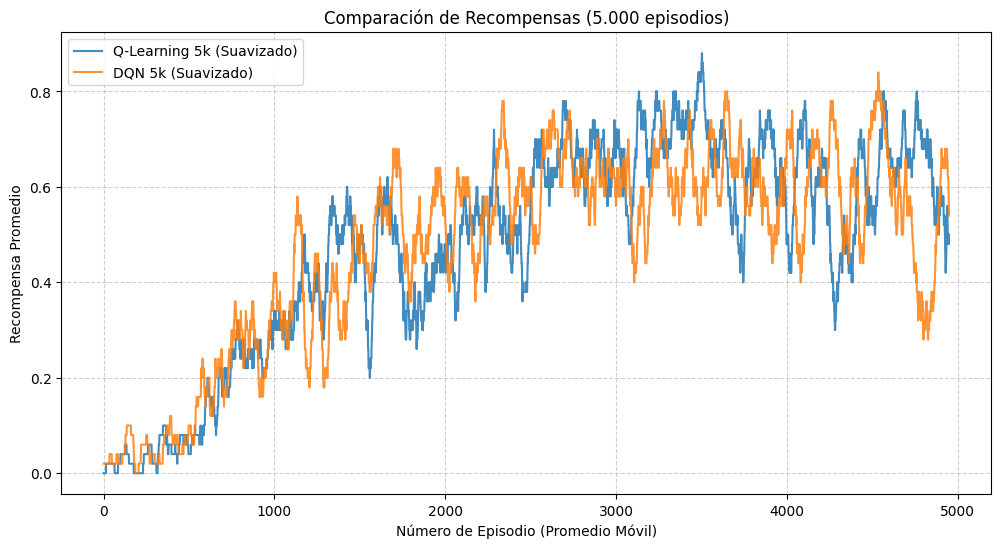

In [ ]:
# Curvas suavizadas (window=50) para 5k
window = 50

def moving_average(data, window_size):
    import numpy as np
    if len(data) < window_size: return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

rq5 = moving_average(recompensas_qlearning_5k, window)
rd5 = moving_average(recompensas_dqn_5k, window)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(rq5, label='Q-Learning 5k (Suavizado)', alpha=0.85)
plt.plot(rd5, label='DQN 5k (Suavizado)', alpha=0.85)
plt.xlabel('Número de Episodio (Promedio Móvil)')
plt.ylabel('Recompensa Promedio')
plt.title('Comparación de Recompensas (5.000 episodios)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()


- Ambos modelos comienzan casi desde cero, sin saber qué hacer → recompensas muy bajas al principio.
- Los dos muestran una fase clara de aprendizaje entre aproximadamente los episodios 800 y 2000, donde la recompensa promedio sube gradualmente.
- A partir de 2000 episodios: Q-Learning Tabular (Azul) se mantiene más estable. DQN (Naranja) tiene un rendimiento similar pero más fluctuante, con subidas y bajadas más marcadas.
- En la fase final (3000–5000 episodios): Ambos alcanzan niveles de recompensa alrededor de 0.6–0.8, lo que coincide con las tasas de éxito finales (~70%). Q-Learning parece un poco más suave y estable, mientras que DQN es más variable.

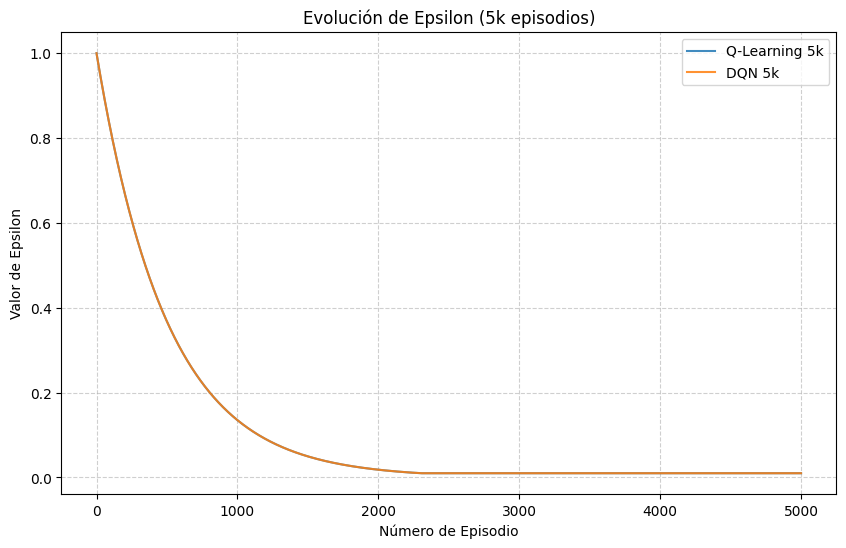

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(agente_qlearning_5k.epsilons, label='Q-Learning 5k', alpha=0.85)
plt.plot(agente_dqn_5k.epsilons, label='DQN 5k', alpha=0.85)
plt.xlabel('Número de Episodio'); plt.ylabel('Valor de Epsilon')
plt.title('Evolución de Epsilon (5k episodios)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()


- En este gráfico se muestra cómo el valor de ε (epsilon) va bajando a medida que avanza el entrenamiento.
Al inicio el agente prueba muchas acciones al azar (explora), y con el tiempo ε se reduce, por lo que el agente empieza a usar lo que aprendió (explota la política).
Se ve que tanto Q-Learning como DQN siguen el mismo comportamiento: exploran mucho al principio y luego consolidan la estrategia aprendida.

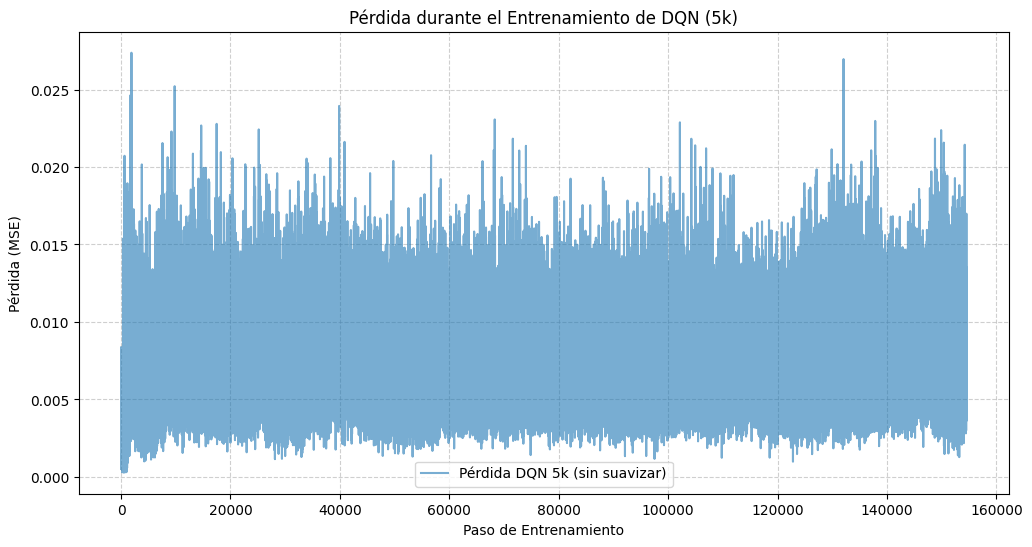

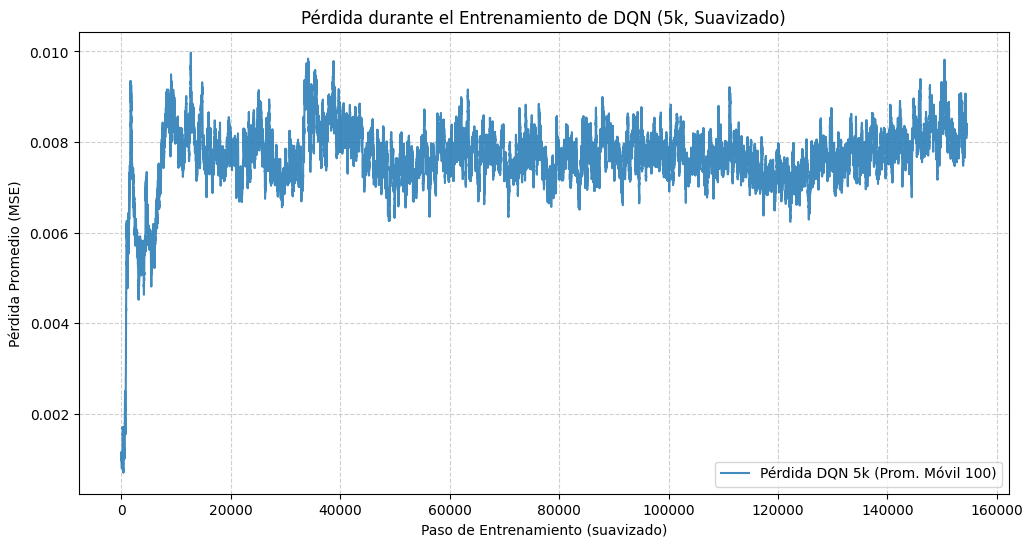

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(agente_dqn_5k.losses, label='Pérdida DQN 5k (sin suavizar)', alpha=0.6)
plt.xlabel('Paso de Entrenamiento'); plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida durante el Entrenamiento de DQN (5k)')
plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.show()

# Suavizado
window_loss = 100
def moving_average(data, window_size):
    import numpy as np
    if len(data) < window_size: return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

losses_dqn_5k_suav = moving_average(agente_dqn_5k.losses, window_loss)

plt.figure(figsize=(12,6))
plt.plot(losses_dqn_5k_suav, label=f'Pérdida DQN 5k (Prom. Móvil {window_loss})', alpha=0.85)
plt.xlabel('Paso de Entrenamiento (suavizado)')
plt.ylabel('Pérdida Promedio (MSE)')
plt.title('Pérdida durante el Entrenamiento de DQN (5k, Suavizado)')
plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.show()


- Este gráfico muestra cómo fue cambiando la pérdida (loss) del modelo DQN durante los 5.000 episodios de entrenamiento.
En las primeras etapas, la pérdida es más alta y variable, porque el modelo todavía está aprendiendo y ajustando los valores Q.
Con el tiempo, la pérdida baja y se estabiliza alrededor de un valor pequeño, lo que indica que el modelo está aprendiendo una política más consistente.
La curva suavizada (abajo) permite ver mejor esta tendencia:
*Al principio aprende rápido, y luego se estabiliza cuando ya tiene una estrategia más madura.*

## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

In [ ]:
# Experimentos DQN con distintos gamma
gammas = [0.80, 0.95, 0.99]  # bajo, medio, alto
resultados = []

# Para guardar series (opcional, por si querés graficar)
hist_losses = {}
hist_rewards = {}
hist_eps = {}

EPISODIOS_TRAIN = 5000     # mismo que en el punto A
EPISODIOS_TEST  = 1000

for g in gammas:
    print(f"\n========== Entrenando DQN con gamma={g} ==========")
    agente = DQNAgent(
        state_size=env.observation_space.n,
        action_size=env.action_space.n,
        lr=0.001,           # como en A
        gamma=g,            # <- variable del experimento
        epsilon=1.0
    )
    # Ajustes estables que ya usaste
    agente.batch_size = 64
    agente.update_target_frequency = 200
    agente.epsilon_decay = 0.998

    recompensas = agente.entrenar(env, episodios=EPISODIOS_TRAIN)
    tasa_exito, _ = agente.evaluar(env, episodios=EPISODIOS_TEST)

    resultados.append({
        "Gamma": g,
        "Tasa_Éxito_5k": round(tasa_exito, 3)
    })

    # Guardar para gráficos
    hist_losses[g]   = agente.losses[:]                    # pérdidas por step
    hist_rewards[g]  = recompensas[:]                      # recompensas por episodio (0/1)
    hist_eps[g]      = agente.epsilons[:]                  # epsilon por episodio

# Tabla de resultados
import pandas as pd
df_gamma = pd.DataFrame(resultados).sort_values("Gamma").reset_index(drop=True)
df_gamma



========== Entrenando DQN con gamma=0.8 ==========
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.030, Epsilon = 0.670, Loss = 0.0023
Episodio 400: Tasa éxito = 0.040, Epsilon = 0.449, Loss = 0.0029
Episodio 600: Tasa éxito = 0.100, Epsilon = 0.301, Loss = 0.0026
Episodio 800: Tasa éxito = 0.110, Epsilon = 0.202, Loss = 0.0033
Episodio 1000: Tasa éxito = 0.150, Epsilon = 0.135, Loss = 0.0049
Episodio 1200: Tasa éxito = 0.130, Epsilon = 0.091, Loss = 0.0055
Episodio 1400: Tasa éxito = 0.240, Epsilon = 0.061, Loss = 0.0057
Episodio 1600: Tasa éxito = 0.190, Epsilon = 0.041, Loss = 0.0066
Episodio 1800: Tasa éxito = 0.250, Epsilon = 0.027, Loss = 0.0070
Episodio 2000: Tasa éxito = 0.200, Epsilon = 0.018, Loss = 0.0068
Episodio 2200: Tasa éxito = 0.320, Epsilon = 0.012, Loss = 0.0074
Episodio 2400: Tasa éxito = 0.440, Epsilon = 0.010, Loss = 0.0078
Episodio 2600: Tasa éxito = 0.350, Epsilon = 0.010, Loss = 0.0083
Episodio 2800: Tasa éxito = 0.

,Gamma,Tasa_Éxito_5k
0,0.80,0.164
1,0.95,0.723
2,0.99,0.756


γ = 0.99 fue el mejor valor, porque permitió al agente considerar tanto las recompensas actuales como las futuras de forma equilibrada, logrando la mayor tasa de éxito (0.75).

En cambio, γ = 0.8 se enfocó demasiado en lo inmediato y no aprendió una estrategia útil (0.16), mientras que γ = 0.95 aprendió pero de forma más lenta (0.72).

# Gráfico de barras comparativo (tasa de éxito)

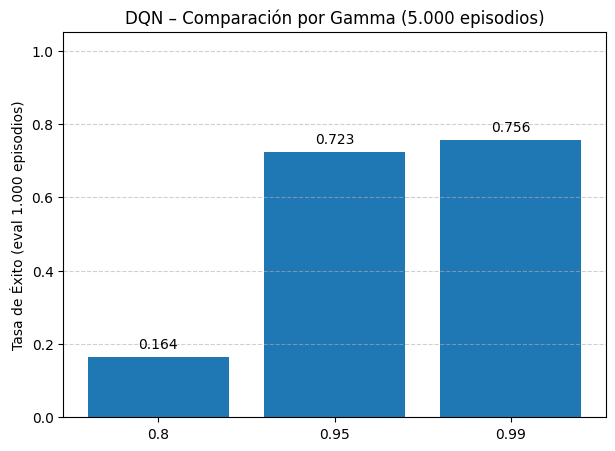

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(df_gamma["Gamma"].astype(str), df_gamma["Tasa_Éxito_5k"])
for x,y in zip(df_gamma["Gamma"].astype(str), df_gamma["Tasa_Éxito_5k"]):
    plt.text(x, y+0.015, f"{y:.3f}", ha="center", va="bottom", fontsize=10)
plt.ylim(0,1.05)
plt.ylabel("Tasa de Éxito (eval 1.000 episodios)")
plt.title("DQN – Comparación por Gamma (5.000 episodios)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


- El gráfico muestra que gamma = 0.99 logra la mayor tasa de éxito (0.75), indicando el mejor equilibrio entre recompensa inmediata y futura.
En cambio, gamma = 0.80 rinde muy mal (0.16) y gamma = 0.95 funciona bien, pero no tanto como gamma = 0.99.

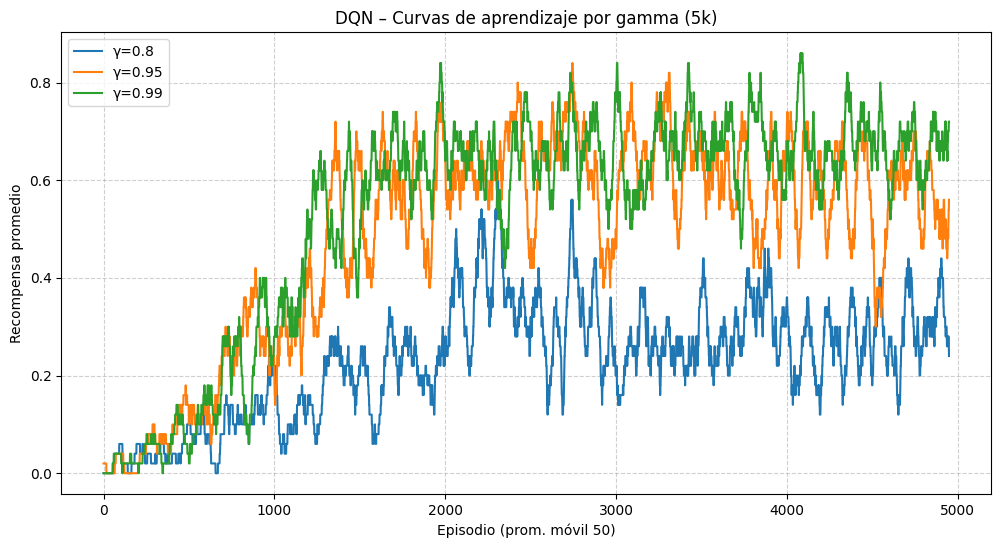

In [ ]:
import numpy as np
def moving_average(a, w=50):
    if len(a) < w: return np.array(a, dtype=float)
    return np.convolve(a, np.ones(w)/w, mode='valid')

plt.figure(figsize=(12,6))
for g in gammas:
    plt.plot(moving_average(hist_rewards[g], 50), label=f"γ={g}")
plt.xlabel("Episodio (prom. móvil 50)")
plt.ylabel("Recompensa promedio")
plt.title("DQN – Curvas de aprendizaje por gamma (5k)")
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


- En el gráfico se ve que γ = 0.8 aprende mal y se queda con recompensas bajas, mientras que γ = 0.95 y γ = 0.99 logran recompensas mucho más altas.
Entre ellos, γ = 0.99 es el más estable y consistente, por eso termina siendo la mejor elección.

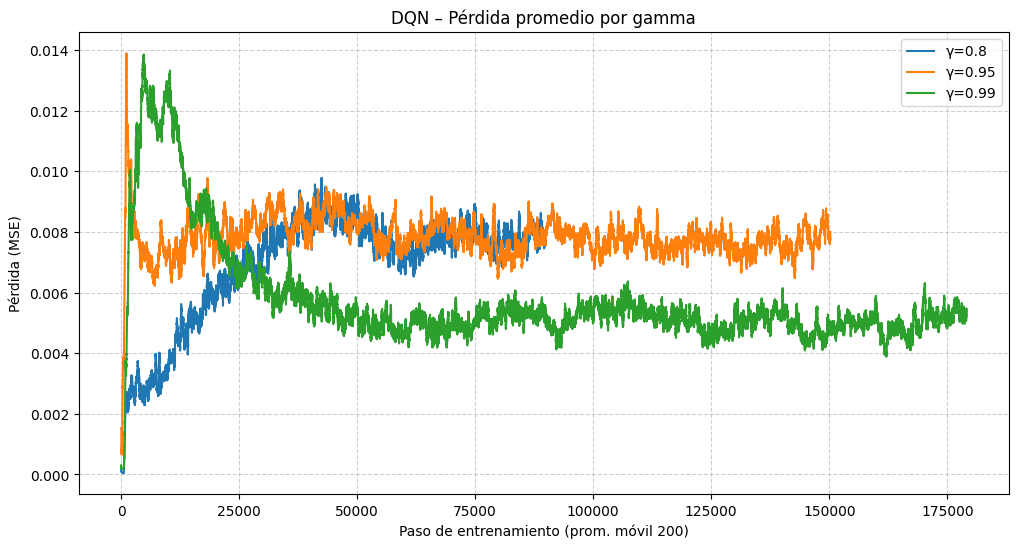

In [ ]:
plt.figure(figsize=(12,6))
for g in gammas:
    L = hist_losses[g]
    if len(L) == 0:
        continue
    Lm = moving_average(L, 200)  # ventana más grande para suavizar loss
    plt.plot(Lm, label=f"γ={g}")
plt.xlabel("Paso de entrenamiento (prom. móvil 200)")
plt.ylabel("Pérdida (MSE)")
plt.title("DQN – Pérdida promedio por gamma")
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


- En el gráfico se ve que γ = 0.99 logra una pérdida más baja y estable a lo largo del entrenamiento, mientras que γ = 0.95 converge bien pero con un poco más de variación.
Por el contrario, γ = 0.8 muestra más ruido y no alcanza una pérdida tan baja, lo que confirma que aprendió peor.

## C) Lo mismo que en B) pero para el hiperparámetro alpha.

Cambiamos alpha (α) → la tasa de aprendizaje del DQN.
Alpha muy chico → aprende lento pero seguro.
Alpha muy grande → aprende rápido pero puede volverse inestable o desaprender.

In [ ]:
# Valores de alpha (lr) a comparar
alphas = [0.0005, 0.001, 0.005]
resultados_alpha = {}
hist_rewards_alpha = {}

for alpha in alphas:
    print(f"\n========== Entrenando DQN con alpha={alpha} ==========")

    agente = DQNAgent(env.observation_space.n, env.action_space.n, lr=alpha, gamma=0.95, epsilon=1.0)
    agente.batch_size = 64
    agente.update_target_frequency = 200
    agente.epsilon_decay = 0.998

    recomp = agente.entrenar(env, episodios=5000)
    tasa_exito, _ = agente.evaluar(env, episodios=1000)

    resultados_alpha[alpha] = tasa_exito
    hist_rewards_alpha[alpha] = recomp




========== Entrenando DQN con alpha=0.0005 ==========
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.010, Epsilon = 0.670, Loss = 0.0096
Episodio 400: Tasa éxito = 0.090, Epsilon = 0.449, Loss = 0.0115
Episodio 600: Tasa éxito = 0.070, Epsilon = 0.301, Loss = 0.0065
Episodio 800: Tasa éxito = 0.170, Epsilon = 0.202, Loss = 0.0061
Episodio 1000: Tasa éxito = 0.220, Epsilon = 0.135, Loss = 0.0082
Episodio 1200: Tasa éxito = 0.470, Epsilon = 0.091, Loss = 0.0071
Episodio 1400: Tasa éxito = 0.440, Epsilon = 0.061, Loss = 0.0081
Episodio 1600: Tasa éxito = 0.530, Epsilon = 0.041, Loss = 0.0088
Episodio 1800: Tasa éxito = 0.500, Epsilon = 0.027, Loss = 0.0070
Episodio 2000: Tasa éxito = 0.610, Epsilon = 0.018, Loss = 0.0079
Episodio 2200: Tasa éxito = 0.600, Epsilon = 0.012, Loss = 0.0086
Episodio 2400: Tasa éxito = 0.550, Epsilon = 0.010, Loss = 0.0085
Episodio 2600: Tasa éxito = 0.610, Epsilon = 0.010, Loss = 0.0084
Episodio 2800: Tasa éxito =

In [ ]:
import pandas as pd

df_alpha = pd.DataFrame({
    "Alpha": list(resultados_alpha.keys()),
    "Tasa_Éxito_5k": list(resultados_alpha.values())
})

df_alpha["Tasa_Éxito_5k"] = df_alpha["Tasa_Éxito_5k"].round(3)
df_alpha


,Alpha,Tasa_Éxito_5k
0,0.0005,0.729
1,0.0010,0.730
2,0.0050,0.262


Con α = 0.0005 y α = 0.001 el DQN aprende de forma estable y alcanza una tasa de éxito ~73%.
Con α = 0.005 el aprendizaje se vuelve inestable, y la tasa de éxito cae a ~26%.

# Gráficos comparativos

- El gráfico muestra que α = 0.001 y α = 0.0005 logran curvas de aprendizaje más estables y con mejores recompensas promedio.
En cambio, α = 0.005 aprende más rápido al inicio, pero se vuelve inestable y termina con un rendimiento menor.

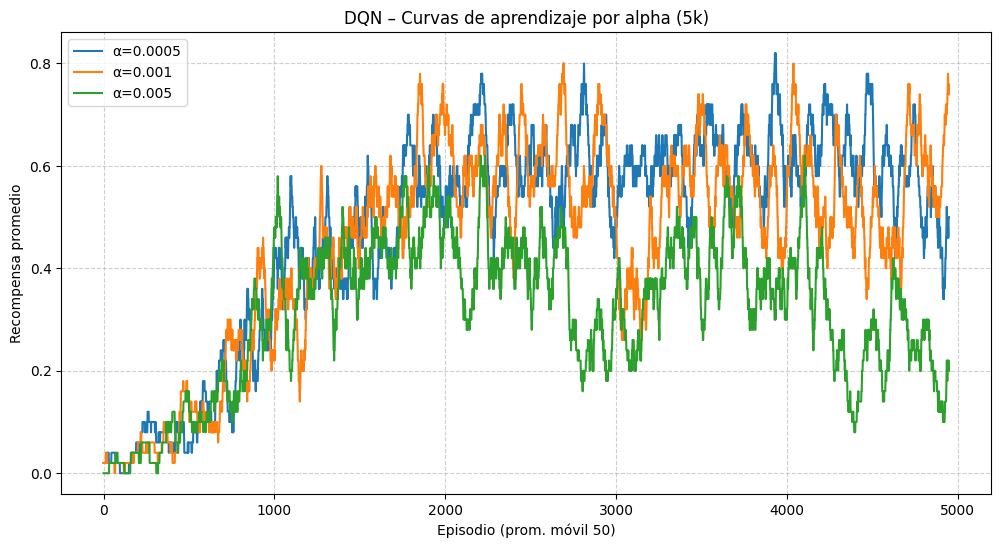

In [ ]:
import numpy as np

def moving_avg(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(12,6))
for a in alphas:
    plt.plot(moving_avg(hist_rewards_alpha[a]), label=f"α={a}")
plt.title("DQN – Curvas de aprendizaje por alpha (5k)")
plt.xlabel("Episodio (prom. móvil 50)")
plt.ylabel("Recompensa promedio")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


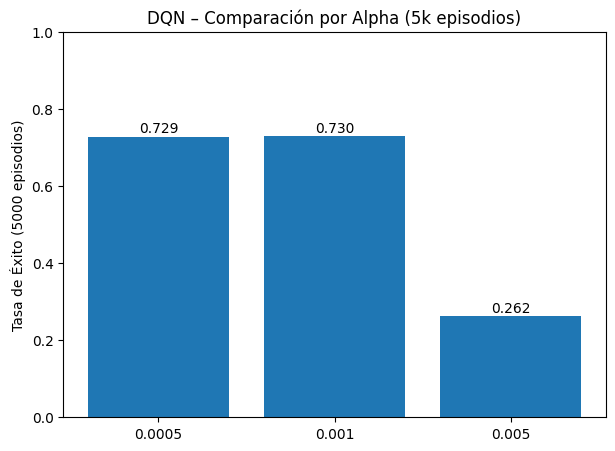

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(df_alpha["Alpha"].astype(str), df_alpha["Tasa_Éxito_5k"])
for x,y in zip(df_alpha["Alpha"].astype(str), df_alpha["Tasa_Éxito_5k"]):
    plt.text(x, y+0.01, f"{y:.3f}", ha='center')
plt.ylim(0,1)
plt.ylabel("Tasa de Éxito (5000 episodios)")
plt.title("DQN – Comparación por Alpha (5k episodios)")
plt.show()


CONCLUSIÓN:

La tasa de aprendizaje (α) tiene un impacto directo en la estabilidad del entrenamiento del DQN.

Valores pequeños, como α = 0.0005 y α = 0.001, permiten que la red neuronal ajuste sus pesos de forma gradual, logrando una política estable y una tasa de éxito cercana al 73% después de 5.000 episodios.

En cambio, con α = 0.005, las actualizaciones se vuelven demasiado agresivas, lo que provoca inestabilidad en el aprendizaje y una caída notable del rendimiento, con una tasa de éxito cercana al 26%.

# REFERENCIAS

- Apuntes y Notebooks de la materia

https://docs.google.com/document/d/1HHuyKr-mvuQZlLT4Bl_l6G7H6bvShlIF3gCaX0cqPMI/edit?tab=t.0#heading=h.zhktkzeezv45

https://colab.research.google.com/drive/1wSK5Kk1Qy8V5WAvZnby3QwKTxLpMeMGn?usp=sharing

https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

http://incompleteideas.net/book/RLbook2020.pdf

- Prompt: "Veo que pasando de 1000 a 5000 episodios, el desempeño mejora, es asi?" (adjunto imagen de los resultados)

- ChatCPT para la ayuda de los gráficos